In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
cd ..

In [113]:
import pandas as pd
import seaborn as sns
sns.set()

In [3]:
import sys
sys.path.append('bin')
from genomic_data import GenomicData

In [225]:
icshape = GenomicData('output/TE/Lu_2016_invitro.hg38/TE_transcript_separate.icshape')

In [226]:
lengths = [icshape.feature('icshape', name).shape[0] for name in icshape.names]

In [227]:
te_types, tx_ids, tx_starts, tx_ends = zip(*[name.split(',') for name in icshape.names])

In [228]:
name_length = pd.DataFrame({'length': lengths, 'te_type': te_types})
def get_unique_counts(x):
    values, counts = np.unique(x['length'], return_counts=True)
    #return pd.Series({'length': ','.join([str(a) for a in values]),
    #                  'count': ','.join([str(a) for a in counts])})
    return pd.Series({'length': values.max(),
                      'count': counts.sum()})
name_count = name_length.groupby('te_type').apply(get_unique_counts)
name_count['count'] = name_count['count'].astype(np.int32)
name_count['length'] = name_count['length'].astype(np.int32)
name_count = name_count.sort_values('count', ascending=False)
name_count.head(50)

count  length
te_type                      
GA-rich           110     142
G-rich             58     109
A-rich             50     134
MIRb               49     259
MIR                39     233
AluJb              37     312
AluSx              34     317
L2a                34     489
AluJr              31     300
AluSx1             27     313
MIRc               26     243
LFSINE_Vert        21     111
AluSz              20     355
AluY               19     323
AluSp              19     321
MIR3               18     199
L2c                18     270
AluSc              18     308
FLAM_C             16     144
U6                 14     107
AluSz6             13     321
AluSx3             12     308
MER5A              12     186
FLAM_A             11     125
MamRTE1            11     187
U1                 11     164
AluJo              11     306
AluSq2             10     316
7SLRNA             10     300
L3                  9     219
L2b                 9     253
L1ME4a              9     336
MER5B               9     157
MIR1_Amn            8     162
L2                  7     285
AluSg               7     308
Penelope1_Vert      7      63
L1MB3               6     392
AluSg4              6     322
OldhAT1             6      63
MER20               5     201
L1ME3G              5     316
L3b                 5     111
L1M5                5     220
Tigger5b            5      77
MamSINE1            5     262
U14                 5      90
Tigger19b           4     129
MER34B-int          4     318
MER96B              4     247

In [191]:
rep_table = pd.read_table('data/UCSC/hg38/RepeatMasker.classes.txt',
                          header=None, names=['repName', 'repClass', 'repFamily'])
print 'Number of repeat names: ', rep_table.shape[0]
print 'Repeat classes: ', ','.join(rep_table['repClass'].unique())
print 'Repeat families: ', ','.join(rep_table['repFamily'].unique())
rep_table.head()

Number of repeat names:  15482
Repeat classes:  rRNA,RNA,srpRNA,Simple_repeat,Satellite,SINE,Low_complexity,DNA,scRNA,LINE,SINE?,LTR,DNA?,Unknown,RC,RC?,LTR?,Retroposon,tRNA,snRNA
Repeat families:  rRNA,RNA,srpRNA,Simple_repeat,acro,centr,Alu,5S-Deu-L2,tRNA-Deu,Low_complexity,hAT-Tip100,scRNA,hAT-Blackjack,Satellite,hAT-Charlie,PIF-Harbinger,CR1,tRNA,TcMar,ERV1,ERVL,DNA?,DNA,Unknown,TcMar?,L1,hAT-Tip100?,Helitron,Helitron?,ERVK,TcMar-Mariner,TcMar-Tc2,L2,RTE-X,PiggyBac,ERV1?,Gypsy,LTR,ERVL?,Gypsy?,Dong-R4,LTR?,TcMar-Tigger,hAT,hAT?,RTE-BovB,tRNA-RTE,TcMar-Pogo,Merlin,MIR,ERVL-MaLR,hAT-Ac,Penelope,telo,MULE-MuDR,SVA,snRNA,hAT-Tag1,PiggyBac?,SINE?


repName       repClass      repFamily
0          5S           rRNA           rRNA
1         7SK            RNA            RNA
2      7SLRNA         srpRNA         srpRNA
3  (AAAAAAC)n  Simple_repeat  Simple_repeat
4  (AAAAAAG)n  Simple_repeat  Simple_repeat

In [214]:
alu_types = rep_table.query('repFamily == "Alu"')['repName']

In [215]:
data = {}
for name in icshape.names:
    te_type = name.split(',')[0]
    if te_type not in data:
        data[te_type] = []
    data[te_type].append(icshape.feature('icshape', name))
for te_type in data.keys():
    max_length = np.max([a.shape[0] for a in data[te_type]])
    m = np.full((len(data[te_type]), max_length), np.nan, dtype=np.float32)
    for i, a in enumerate(data[te_type]):
        m[i, :a.shape[0]] = a
    data[te_type] = m

In [216]:
# summarize coverage of icSHAPE scores on each TE type
te_icshape_coverage = pd.DataFrame(columns=['name', 'te_type', 'length', 'coverage'],
                                  index=np.arange(len(icshape.names)))
for i, name in enumerate(icshape.names):
    te_type = name.split(',')[0]
    a = icshape.feature('icshape', name)
    te_icshape_coverage.iloc[i, :] = [name, te_type, a.shape[0], float(np.sum(~np.isnan(a)))/a.shape[0]]
te_icshape_coverage['coverage'] = te_icshape_coverage['coverage'].astype(np.float32)
te_icshape_coverage.head()

name   te_type length  coverage
0    G-rich,ENST00000379198.3,2028,2072    G-rich     44       0.0
1  X7A_LINE,ENST00000480661.1,1439,1577  X7A_LINE    138       0.0
2    AluSx3,ENST00000343813.9,2557,2865    AluSx3    308       0.0
3      MIRb,ENST00000343813.9,2116,2311      MIRb    195       0.0
4      MIRb,ENST00000489498.5,2255,2450      MIRb    195       0.0

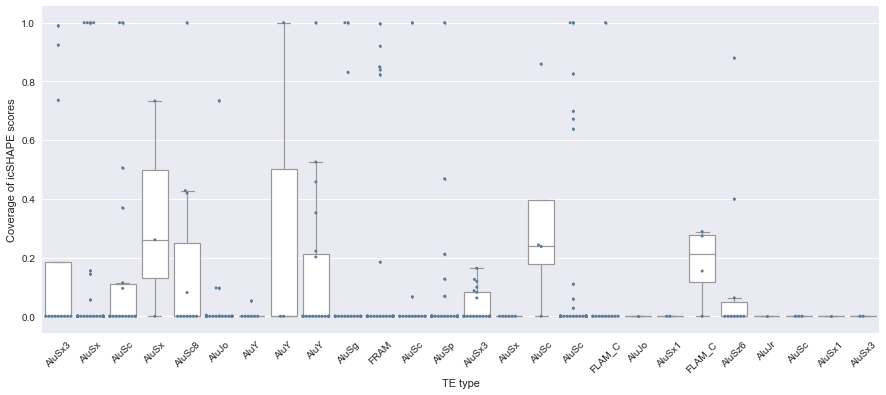

In [219]:
fig, ax = plt.subplots(figsize=(15, 6))
plt_data = te_icshape_coverage[te_icshape_coverage['te_type'].isin(alu_types)]
sns.boxplot(x='te_type', y='coverage', 
            data=plt_data, 
            fliersize=3, color='w', linewidth=1.2, ax=ax)
sns.swarmplot(x='te_type', y='coverage', 
            data=plt_data,
            color='#577b98', size=3, ax=ax)
ax.set_xlabel('TE type')
ax.set_xticklabels(plt_data['te_type'], rotation=45)
ax.set_ylabel('Coverage of icSHAPE scores')

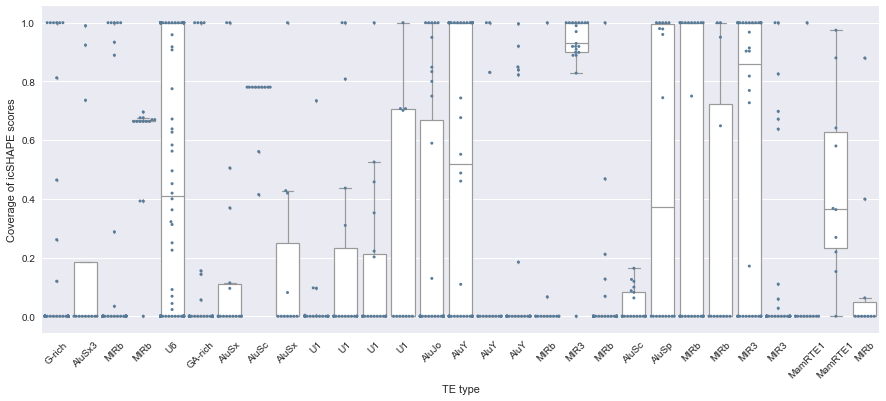

In [220]:
# get TE types with >= 10 instances
te_icshape_coverage_mean = te_icshape_coverage.groupby('te_type')['coverage'].mean()
te_icshape_coverage_count = te_icshape_coverage.groupby('te_type')['coverage'].count()
te_types_top = te_icshape_coverage_mean[te_icshape_coverage_count >= 10].index.tolist()
# plot coverage vs TE type
fig, ax = plt.subplots(figsize=(15, 6))
plt_data = te_icshape_coverage[te_icshape_coverage['te_type'].isin(te_types_top)]
sns.boxplot(x='te_type', y='coverage', 
            data=plt_data, 
            fliersize=3, color='w', linewidth=1.2, ax=ax)
sns.swarmplot(x='te_type', y='coverage', 
            data=plt_data,
            color='#577b98', size=3, ax=ax)
ax.set_xticklabels(plt_data['te_type'], rotation=45)
ax.set_xlabel('TE type')
ax.set_ylabel('Coverage of icSHAPE scores')

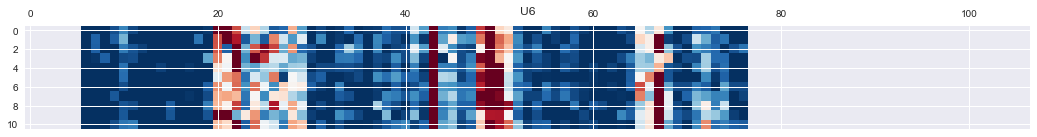

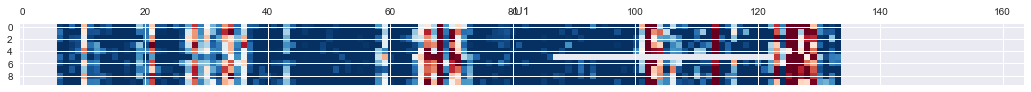

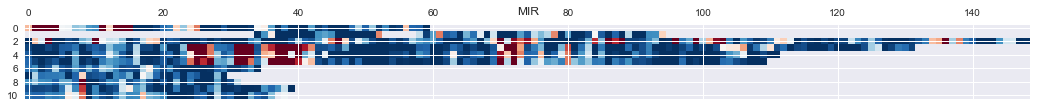

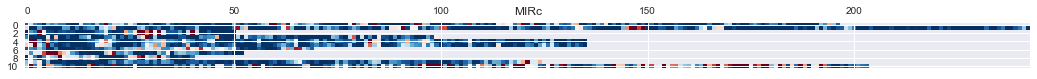

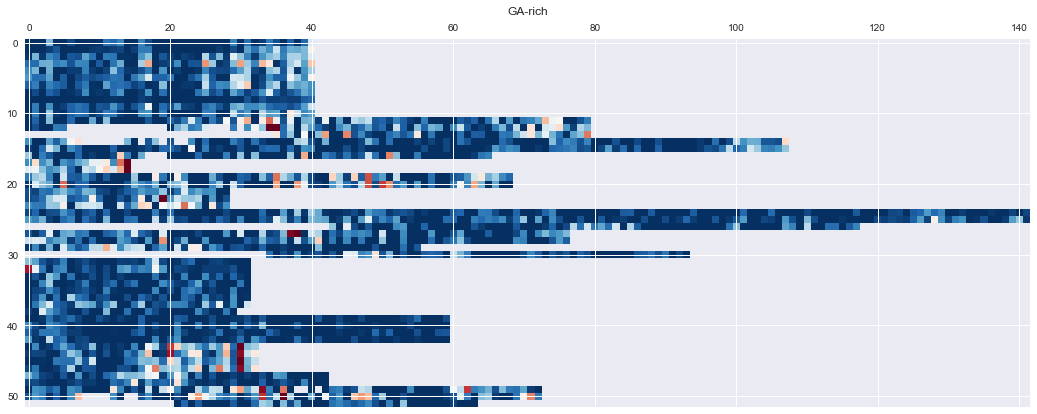

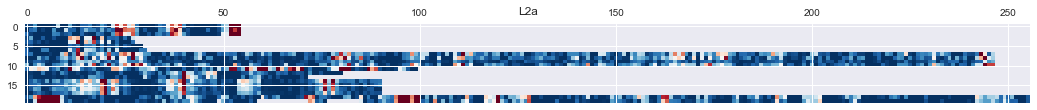

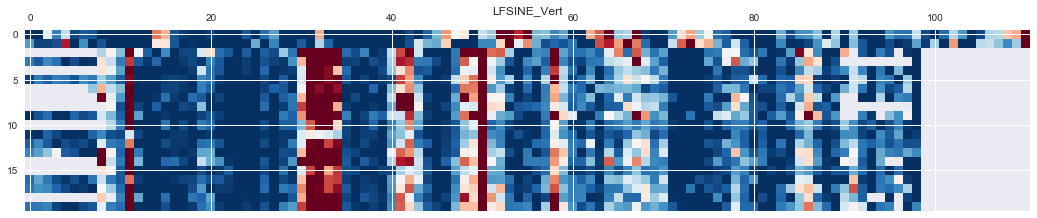

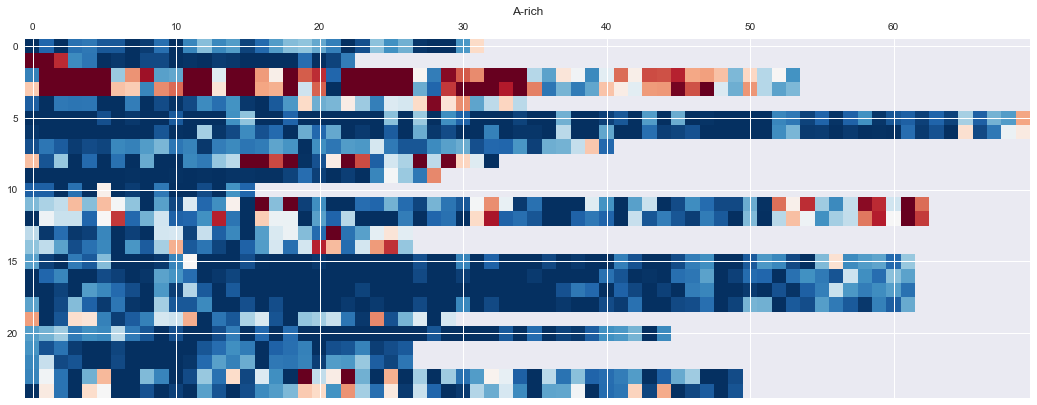

In [221]:
# plot heatmaps for TE types with coverage >= 50% and number of instances >= 10
mat = {}
for name in icshape.names:
    te_type = name.split(',')[0]
    if te_type not in mat:
        mat[te_type] = []
    a = icshape.feature('icshape', name)
    if float(np.sum(~np.isnan(a)))/a.shape[0] >= 0.5:
        mat[te_type].append(icshape.feature('icshape', name))
mat = {te_type:value for te_type, value in mat.items() if len(value) > 0}
# create a matrix for each TE type
# For sequences shorter than maximum length, NaNs are padded
for te_type in mat.keys():
    max_length = np.max([a.shape[0] for a in mat[te_type]])
    m = np.full((len(mat[te_type]), max_length), np.nan, dtype=np.float32)
    for i, a in enumerate(mat[te_type]):
        m[i, :a.shape[0]] = a
    mat[te_type] = m
# draw a heatmap with icSHAPE scores for each TE type
for te_type in mat.keys():
    if mat[te_type].shape[0] >= 10:
        fig, ax = plt.subplots(figsize=(18, 8))
        ax.matshow(mat[te_type], cmap=cm.RdBu_r)
        ax.set_title(te_type)

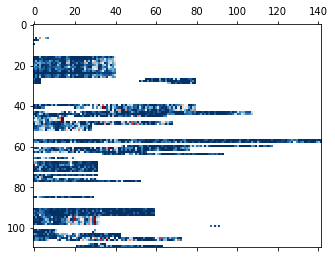

In [79]:
matshow(data['GA-rich'], cmap=cm.RdBu_r)

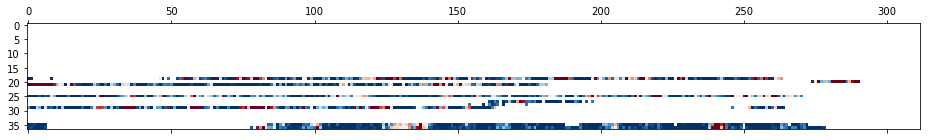

In [80]:
matshow(data['AluJb'], cmap=cm.RdBu_r)

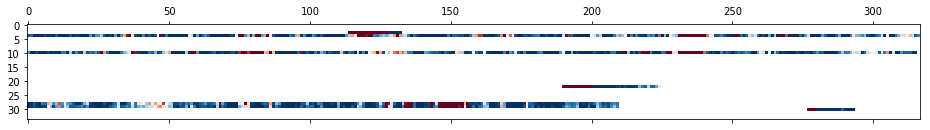

In [81]:
matshow(data['AluSx'], cmap=cm.RdBu_r)

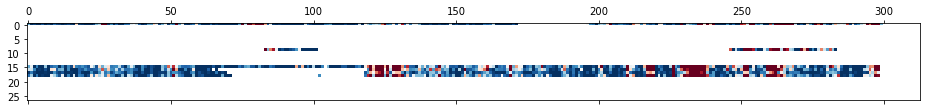

In [82]:
matshow(data['AluSx1'], cmap=cm.RdBu_r)

In [33]:
name_count['count'].dtype

dtype('O')

In [222]:
name_length = pd.DataFrame({'length': lengths, 'te_type': te_types})
def get_unique_counts(x):
    values, counts = np.unique(x['length'], return_counts=True)
    #return pd.Series({'length': ','.join([str(a) for a in values]),
    #                  'count': ','.join([str(a) for a in counts])})
    return pd.Series({'length': values.max(),
                      'count': counts.sum()})
name_count = name_length.groupby('te_type').apply(get_unique_counts)
name_count['count'] = name_count['count'].astype(np.int32)
name_count['length'] = name_count['length'].astype(np.int32)
name_count = name_count.sort_values('count', ascending=False)
name_count.head(50)

count  length
te_type                      
GA-rich           110     142
G-rich             58     109
A-rich             50     134
MIRb               49     259
MIR                39     233
AluJb              37     312
AluSx              34     317
L2a                34     489
AluJr              31     300
AluSx1             27     313
MIRc               26     243
LFSINE_Vert        21     111
AluSz              20     355
AluY               19     323
AluSp              19     321
MIR3               18     199
L2c                18     270
AluSc              18     308
FLAM_C             16     144
U6                 14     107
AluSz6             13     321
AluSx3             12     308
MER5A              12     186
FLAM_A             11     125
MamRTE1            11     187
U1                 11     164
AluJo              11     306
AluSq2             10     316
7SLRNA             10     300
L3                  9     219
L2b                 9     253
L1ME4a              9     336
MER5B               9     157
MIR1_Amn            8     162
L2                  7     285
AluSg               7     308
Penelope1_Vert      7      63
L1MB3               6     392
AluSg4              6     322
OldhAT1             6      63
MER20               5     201
L1ME3G              5     316
L3b                 5     111
L1M5                5     220
Tigger5b            5      77
MamSINE1            5     262
U14                 5      90
Tigger19b           4     129
MER34B-int          4     318
MER96B              4     247

In [63]:
name_count.loc['AluY']

count                             1,1,3,3,1,1,1,1,1,1,1,1,3
length    278,285,289,290,295,296,297,302,308,311,315,32...
Name: AluY, dtype: object

In [12]:
np.unique(lengths, return_counts=True)

(array([   7,   11,   12,   14,   17,   18,   19,   20,   21,   22,   23,
          24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,
          35,   36,   37,   38,   39,   40,   41,   42,   43,   44,   45,
          46,   47,   48,   49,   50,   51,   52,   53,   54,   55,   56,
          57,   58,   59,   60,   61,   62,   63,   64,   65,   66,   67,
          68,   69,   70,   71,   72,   73,   74,   76,   77,   78,   79,
          81,   82,   84,   85,   86,   87,   88,   89,   91,   92,   93,
          94,   95,   96,   98,   99,  100,  101,  102,  103,  105,  106,
         107,  111,  112,  113,  114,  115,  117,  118,  119,  122,  125,
         126,  127,  128,  129,  130,  131,  132,  133,  136,  138,  139,
         142,  143,  144,  149,  150,  156,  157,  159,  162,  164,  169,
         170,  175,  176,  179,  182,  185,  186,  189,  190,  192,  198,
         199,  200,  204,  207,  208,  214,  217,  219,  223,  226,  235,
         241,  245,  247,  252,  253, 

In [207]:
rep_table[~rep_table['repClass'].isin(['Simple_repeat', 'Unknown', 'SINE?', 'DNA?', 'RNA?', 'RC?', 'LTR?'])]

repName   repClass     repFamily
0             5S       rRNA          rRNA
1            7SK        RNA           RNA
2         7SLRNA     srpRNA        srpRNA
1500       ACRO1  Satellite          acro
2596   ALR/Alpha  Satellite         centr
2597       AluJb       SINE           Alu
2598       AluJo       SINE           Alu
2599      AluJr4       SINE           Alu
2600       AluJr       SINE           Alu
2601      AluSc5       SINE           Alu
2602      AluSc8       SINE           Alu
2603       AluSc       SINE           Alu
2604      AluSg4       SINE           Alu
2605      AluSg7       SINE           Alu
2606       AluSg       SINE           Alu
2607         Alu       SINE           Alu
2608       AluSp       SINE           Alu
2609     AluSq10       SINE           Alu
2610      AluSq2       SINE           Alu
2611      AluSq4       SINE           Alu
2612       AluSq       SINE           Alu
2613      AluSx1       SINE           Alu
2614      AluSx3       SINE           Alu
2615      AluSx4       SINE           Alu
2616       AluSx       SINE           Alu
2617      AluSz6       SINE           Alu
2618       AluSz       SINE           Alu
2619      AluYa5       SINE           Alu
2620      AluYa8       SINE           Alu
2621      AluYb8       SINE           Alu
...          ...        ...           ...
15379   UCON132b        DNA    hAT-Tip100
15390     UCON23        DNA   hAT-Tip100?
15398     UCON29        DNA     PiggyBac?
15401     UCON33        DNA  TcMar-Tigger
15406     UCON39        DNA  TcMar-Tigger
15414     UCON49       LINE            L2
15420     UCON55        DNA  TcMar-Tigger
15435     UCON69        DNA          hAT?
15446     UCON78        DNA           DNA
15450     UCON80        DNA          hAT?
15451     UCON81        DNA   hAT-Charlie
15456     UCON86       LINE            L2
15459     UCON89        DNA          hAT?
15460      UCON8        DNA           DNA
15465     UCON97        DNA           DNA
15466     UCON99        DNA           DNA
15468    X1_LINE       LINE           CR1
15469    X2_LINE       LINE           CR1
15470   X5B_LINE       LINE           CR1
15471   X6A_LINE       LINE           CR1
15472   X6B_LINE       LINE           CR1
15473   X7A_LINE       LINE           CR1
15474   X7B_LINE       LINE           CR1
15475   X7C_LINE       LINE           CR1
15476   X7D_LINE       LINE           CR1
15477    X8_LINE       LINE           CR1
15478    X9_LINE       LINE            L1
15479    Zaphod2        DNA    hAT-Tip100
15480    Zaphod3        DNA    hAT-Tip100
15481     Zaphod        DNA    hAT-Tip100

[1171 rows x 3 columns]